In [75]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
%matplotlib inline

import inspect
import sys
import re

def look():
    for name, val in sys._getframe(1).f_locals.items():
        if inspect.ismodule(val):
            fullnm = str(val)
            if not '(built-in)' in fullnm and not __name__ in fullnm:
                module,path = re.search(r"'(.+)'.*'(.+)'", fullnm).groups()
                if hasattr(val, '__version__'):
                    print("{}: {}".format(name, val.__version__, path))
                else:
                    print("{}: -- ".format(name))
look()

np: 1.14.3
pd: 0.23.3
scipy: 1.1.0
plt: -- 
sns: 0.9.0
nx: 2.1
cm: -- 
colors: -- 
inspect: -- 
re: 2.2.1


# What can we learn from a network?

For this guided example, we'll be working with the [Human Disease Network](http://www.pnas.org/content/104/21/8685.full), a network linking diseases by their shared genetic associations.  Two diseases are connected if they are associated with the same genetic mutation.  Weights represent the number of genetic mutations shared between diseases. Diseases themselves fall within classes: Cancer, endocrine disorders, metabolic disorders, etc.  

One question of interest is whether the gene-driven links between diseases will cause the diseases to cluster by class-- in other words, will all the cancer-type diseases cluster together and separate from the other classes of diseases?   Or do many different diseases from different classes share links to the same mutated genes? 

Let's find out!  We will create a network from the list of disease links and add disease class as an attribute.  Then we can examine the overall disease network for patterns.  Finally, we can look at whether the connections among diseases reflects their class structure, using connectedness, clustering, and measures of centrality.

In [2]:
# loading the list of edge and weights
edges = pd.read_table('../data/nx/nxpractice.txt',skiprows=0,sep=" ")

In [3]:
edges.head()

,#Disease_id1,Disease_id2,Weight
0,9,1144,1
1,13,990,1
2,14,121,1
3,14,1446,1
4,15,681,1


In [4]:
edges.values

array([[   9, 1144,    1],
       [  13,  990,    1],
       [  14,  121,    1],
       ...,
       [9308, 1054,    1],
       [9308, 1352,    1],
       [9308,  750,    1]])

In [5]:
# Converting to a list of tuples including the 'weight' attribute
tuples = [(x[0],x[1],{"weight":x[2]}) for x in edges.values]

In [6]:
# Making an empty graph.
diseases=nx.Graph()

# Adding edges will automatically add nodes.
diseases.add_edges_from(tuples)

In [7]:
# Loading the list of node characteristics
nodes = pd.read_table('../data/nx/nxpractice2.txt',skiprows=1,sep="\t")

In [8]:
nodes.head()

,Disease ID,Name,Disorder class,Size (s),Degree (k),Class-degree (k),Genes implicated (Entrez ID) [comma-deliminated]
0,1,"17,20-lyase_deficiency",Endocrine,1,0,0,CYP17A1 (1586)
1,3,2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...,Metabolic,1,0,0,HADH2 (3028)
2,4,2-methylbutyrylglycinuria,Metabolic,1,0,0,ACADSB (36)
3,5,"3-beta-hydroxysteroid_dehydrogenase,_type_II,_...",Metabolic,1,0,0,HSD3B2 (3284)
4,6,3-hydroxyacyl-CoA_dehydrogenase_deficiency,Metabolic,1,0,0,HADHSC (3033)


In [9]:
# Getting rid of some extra variables we don't want to work with.
nodes=nodes[['Disease ID', 'Name','Disorder class','Genes implicated (Entrez ID) [comma-deliminated]']]
nodes.head()

,Disease ID,Name,Disorder class,Genes implicated (Entrez ID) [comma-deliminated]
0,1,"17,20-lyase_deficiency",Endocrine,CYP17A1 (1586)
1,3,2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...,Metabolic,HADH2 (3028)
2,4,2-methylbutyrylglycinuria,Metabolic,ACADSB (36)
3,5,"3-beta-hydroxysteroid_dehydrogenase,_type_II,_...",Metabolic,HSD3B2 (3284)
4,6,3-hydroxyacyl-CoA_dehydrogenase_deficiency,Metabolic,HADHSC (3033)


In [10]:
# Adding attributes to the nodes in the graph.
for node in nodes['Disease ID']:
    if node in diseases.nodes():
        diseases.node[node]['name'] = nodes.loc[nodes['Disease ID']==node,'Name'].values[0]
        diseases.node[node]['class'] = nodes.loc[nodes['Disease ID']==node,'Disorder class'].values[0]
        diseases.node[node]['genes'] = nodes.loc[nodes['Disease ID']==node,'Genes implicated (Entrez ID) [comma-deliminated]'].values[0]
    
print(diseases.node[9])

{'name': '3-methylglutaconicaciduria', 'class': 'Metabolic', 'genes': 'OPA3 (80207)'}


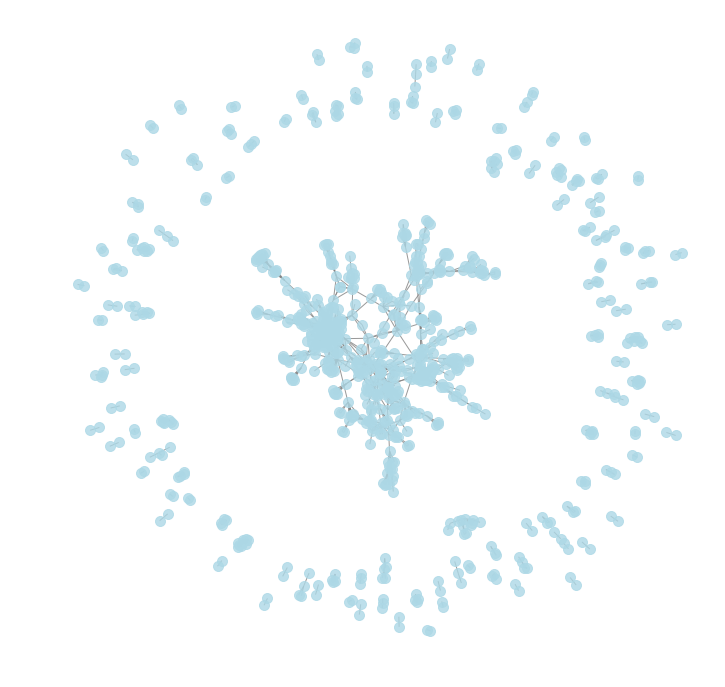

In [11]:
#Drawing the basic graph

plt.rcParams['figure.figsize']=[12,12]
nx.draw_networkx(diseases,
                 pos=nx.spring_layout(diseases,weight='weights'), 
                 node_color='lightblue',
                 edge_color='gray',
                 node_size=100,
                 with_labels=False,
                 alpha=.8
                 )
plt.axis('off')
plt.show()

# First Impressions

We haven't yet added any markers to tell us which diseases belong to which classes, but the splatter-ring pattern we see certainly isn't what we would expect if each disease class kept to its own pile of genetic mutations!  A class-consistent network would involve a number of clusters (equal to the number of classes) that share many connections, with a smaller number of connections between nodes of different classes.  

Before we dive in to the classes, let's get some numbers to quantify our impressions.  Particularly, we want to see what our degree distribution is, how much clustering there is, and identify which diseases are most central.  We'll also see how many connected networks there are within the larger unconnected network.

In [12]:
numberofnodes=diseases.number_of_nodes()
nodedegrees=list(dict(diseases.degree()).values())
av_degree=np.mean(nodedegrees)
med_degree=np.median(nodedegrees)
clustering=list(nx.clustering(diseases).values())
betweenness_cent=list(nx.betweenness_centrality(diseases).values())
componentsizes=[len(c) for c in sorted(nx.connected_components(diseases), key=len, reverse=True)]

This graph has 867 nodes and 1527 edges.
The median degree is 2.0 and the mean degree is 3.5224913494809686.
A disease node with median degree is connected to 0.2306805074971165% of other diseases.
There are 123 connected components within the graph.


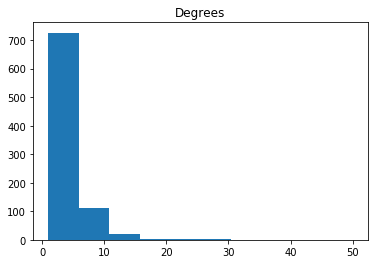

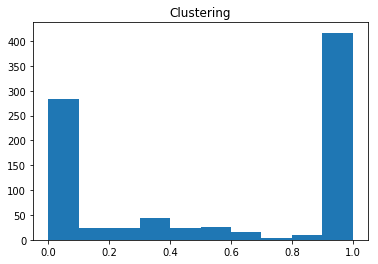

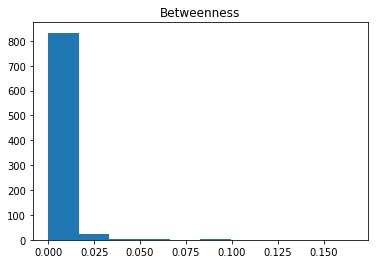

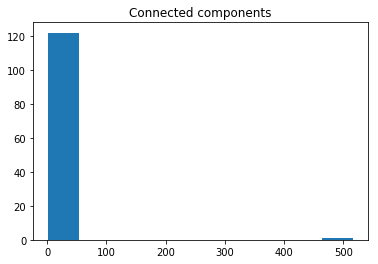

In [13]:
print("This graph has {} nodes and {} edges.".format(diseases.number_of_nodes(),diseases.number_of_edges()))

print("The median degree is {} and the mean degree is {}.".format(med_degree,av_degree))

print("A disease node with median degree is connected to {}% of other diseases.".format((med_degree/numberofnodes)*100))

print("There are {} connected components within the graph.".format(nx.number_connected_components(diseases)))

plt.rcParams['figure.figsize']=[6,4]

plt.hist(nodedegrees)
plt.title('Degrees')
plt.show()

plt.hist(clustering)
plt.title('Clustering')
plt.show()

plt.hist(betweenness_cent)
plt.title('Betweenness')
plt.show()

plt.hist(componentsizes)
plt.title('Connected components')
plt.show()

# Second Look

As is typical, the network is sparse: As shown in the degree histogram, most nodes are not connected to many other nodes, though there is that outlier with about 50 degrees in the histogram.  The clustering histogram is very interesting-- supporting our visual inspection of the graph, it appears that about half of the diseases cluster very tightly indeed, all sharing links, while a third have little to no overlap in their relationships with other nodes.  

Since this network is unconnected (we can't travel from one node to any other node following edges), betweenness centrality scores are low overall.  In fact, with 123 connected components spread out over only 867 nodes, there seem to be a lot of groupings of two to three nodes that are completely offset from all other nodes-- we see that in the connected components histogram.

Now let's look how the various node attributes are associated with each other.

In [14]:
# Pulling our node-level statistics together into a dataframe.
graph_stats=pd.DataFrame({'node':list(dict(diseases.degree()).keys()),
                          'degree':list(dict(diseases.degree()).values()),
                          'clustering':list(dict(nx.clustering(diseases)).values()),
                          'betweenness_cent':list(dict(nx.betweenness_centrality(diseases)).values())
                         })

# Assigning each node to a component by number.
graph_stats['component']=None

# Sorting the components by size so that the largest component will be numbered 0.
components=sorted(nx.connected_components(diseases), key=len, reverse=True)
for i,component in enumerate(components):
    graph_stats.loc[graph_stats['node'].isin(list(component)),'component']=i
    
print(graph_stats.head())

   node  degree  clustering  betweenness_cent  component
0     9       1    0.000000          0.000000          0
1  1144       2    0.000000          0.001372          0
2    13       1    0.000000          0.000000          0
3   990      14    0.186813          0.012232          0
4    14       2    1.000000          0.000000         24


In [15]:
# Logging these two for easier relationship viewing.
graph_stats['log_between']=np.log(graph_stats['betweenness_cent']+.001)
graph_stats['log_degree']=np.log(graph_stats['degree']+1)

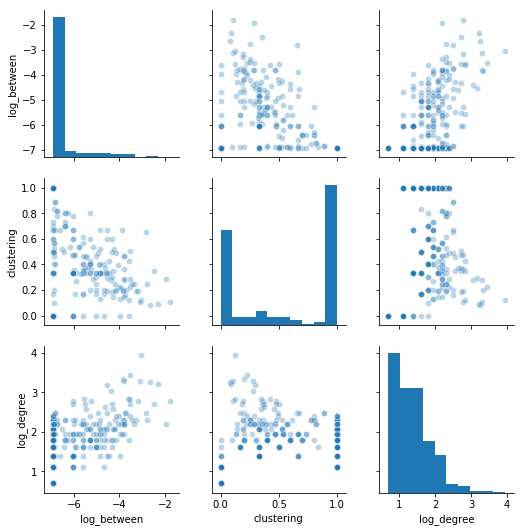

In [16]:
g = sns.pairplot(graph_stats,
                 vars=['log_between','clustering','log_degree'],
                 kind='scatter',
                plot_kws={'alpha':.3})
plt.show()

## Node characteristics

It appears that very high betweenness centrality is related to lower clustering, suggesting that diseases that are part of the simple paths between many other diseases tend not to be part of clusters themselves.  However, for medium and low betweenness centrality there does not appear to be any relationship with clustering.  

Degree is positively related to betweenness centrality, which makes sense: A disease is more likely to be part of the simple path between two other diseases if it links to many other diseases.

Degree and clustering do not appear to share a relationship.  This is odd, because one would expect that the more diseases a node is linked to (degree) the higher likelihood that some of those diseases will not be linked to each other (clustering).  However, it appears this is not the case.  

# Node Attribute Interactions

Now let's see what we can gain by adding the disease class information to the mix:

,node,degree,clustering,betweenness_cent,component,log_between,log_degree,Disease ID,Name,Disorder class,Genes implicated (Entrez ID) [comma-deliminated]
0,9.0,1.0,0.000000,0.000000,0.0,-6.907755,0.693147,9,3-methylglutaconicaciduria,Metabolic,OPA3 (80207)
1,1144.0,2.0,0.000000,0.001372,0.0,-6.043882,1.098612,1144,Optic_atrophy,Ophthamological,"OPA1 (4976), OPA3 (80207)"
2,13.0,1.0,0.000000,0.000000,0.0,-6.907755,0.693147,13,Aarskog-Scott_syndrome,multiple,FGD1 (2245)
3,990.0,14.0,0.186813,0.012232,0.0,-4.325104,2.708050,990,Mental_retardation,Neurological,"PRSS12 (8492), CRBN (51185), NLGN4X (57502), M..."
4,14.0,2.0,1.000000,0.000000,24.0,-6.907755,1.098612,14,Abacavir_hypersensitivity,Immunological,HLA-B (3106)


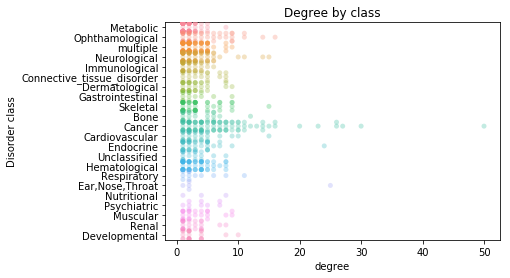

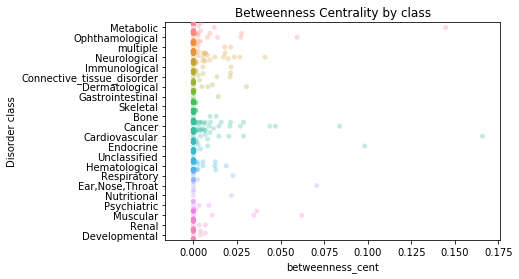

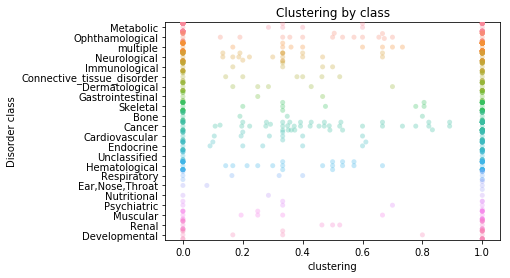

In [18]:
# Merging our statistics with the original node information.
disease_stats=pd.merge(graph_stats,nodes,left_on='node',right_on='Disease ID',how='outer')
disease_stats.head()

# Plotting node stats by class

sns.swarmplot(x="degree", y="Disorder class", data=disease_stats,alpha=.3)
plt.title('Degree by class')
plt.show()

sns.swarmplot(x="betweenness_cent", y="Disorder class", data=disease_stats,alpha=.3)
plt.title('Betweenness Centrality by class')
plt.show()

sns.swarmplot(x="clustering", y="Disorder class", data=disease_stats,alpha=.3)
plt.title('Clustering by class')
plt.show()



# Classes and node characteristics

Unsurprisingly, the largest class (Cancer) also has the node with the highest degree, as evident in the 'degree by class' plot.  For the other classes, most nodes in the class are of low degree.  This suggests that, aside from cancer, the classes don't differ much in the tendency of their diseases to share genetic mutations with other diseases.  

Betweenness centrality is difficult to interpret for this data.  If a disease has high betweenness centrality, that means that it part of a pathway between two other diseases, connected by shared genetic mutations.    None of the classes seem particularly likely to have nodes with high betweenness centrality, though a couple are very low in it, perhaps indicating that their genetic mutations are more specific to particular diseases.

Clustering seems to be all over the place- there aren't any patterns evident in the plot.

Next, let's look at how the classes map onto the connected components (sub-graphs where it is possible to travel from any node in the sub-graph to any other node in the sub-graph).

In [19]:
print('The number of nodes in each class:')
nodesbyclass=disease_stats.groupby(by='Disorder class')['component'].count()
print(nodesbyclass)

print('\nThe number of connected components that members of each class belong to.')
componentsbyclass=disease_stats.groupby(by='Disorder class')['component'].apply(lambda x: len(set(x)))
print(componentsbyclass)

#A class with more nodes has more opportunities to belong to multiple components, so we'll divide by number of nodes.
print("\nNumber of components by class normalized by number of nodes.")
print(componentsbyclass/nodesbyclass)

The number of nodes in each class:
Disorder class
Bone                           24
Cancer                         99
Cardiovascular                 33
Connective_tissue_disorder     20
Dermatological                 37
Developmental                  23
Ear,Nose,Throat                 5
Endocrine                      40
Gastrointestinal               14
Hematological                  67
Immunological                  39
Metabolic                      91
Muscular                       22
Neurological                   78
Nutritional                     3
Ophthamological                48
Psychiatric                     9
Renal                          22
Respiratory                    12
Skeletal                       53
Unclassified                   18
multiple                      110
Name: component, dtype: int64

The number of connected components that members of each class belong to.
Disorder class
Bone                           14
Cancer                         23
Cardiovascular 

# Preliminary conclusions about classes and components

It was clear from viewing the graph of the network at the beginning that there wasn't going to be a one to one matching of disease classes to connected components.  With 23 classes and over 100 components, heterogeneity is expected.  

Looking at the normalized components by class scores above, we see that some disease classes are organized into a small number of components, representing potential specificity (diseases within the class are more likely to share a connected network with one another and not with diseases of other classes).  Lower normalized total component scores (the number of components represented in a class, divided by the number of nodes in the class) indicate higher specificity.  It appears that Cancer is the most specific, belonging to only 10 components despite having 99 nodes, followed by Opthamological disorders.  The most spread-out class is Ear, Nose, and Throat, with 4 components for its 5 nodes.  The next highest is Nutritional, with 2 components for 3 nodes, then Developmental, with 14 components over 23 nodes. 

We can also turn the question around and discover which classes possess homogenous connected components, that is, connected sub-networks that only contain diseases from one class:

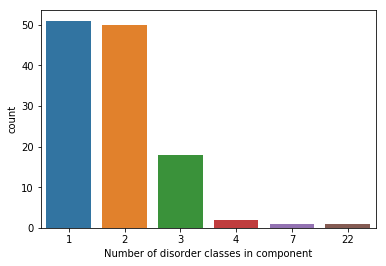

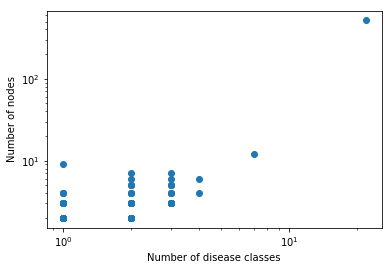

component
2.0         [Hematological, 9]
17.0            [Metabolic, 4]
19.0            [Metabolic, 4]
21.0             [Skeletal, 4]
34.0            [Metabolic, 3]
41.0        [Hematological, 3]
42.0        [Hematological, 3]
47.0            [Metabolic, 3]
50.0            [Metabolic, 3]
52.0       [Dermatological, 3]
53.0          [Respiratory, 3]
54.0             [Skeletal, 2]
55.0       [Dermatological, 2]
57.0       [Dermatological, 2]
59.0             [Muscular, 2]
60.0                [Renal, 2]
61.0        [Hematological, 2]
62.0     [Gastrointestinal, 2]
63.0        [Hematological, 2]
66.0         [Neurological, 2]
67.0        [Hematological, 2]
69.0        [Hematological, 2]
70.0             [Muscular, 2]
72.0      [Ophthamological, 2]
74.0                 [Bone, 2]
75.0         [Neurological, 2]
76.0     [Gastrointestinal, 2]
77.0            [Metabolic, 2]
80.0             [Skeletal, 2]
81.0            [Metabolic, 2]
82.0       [Cardiovascular, 2]
84.0            [Metabolic, 2

In [20]:
#Count of nodes in components
nodesbycomponent=disease_stats.groupby(by='component')['Disorder class'].count()

#The number of classes that members of each component belong to.
classesbycomponent=disease_stats.groupby(by='component')['Disorder class'].apply(lambda x: len(set(x)))

sns.countplot(classesbycomponent)
plt.xlabel('Number of disorder classes in component')
plt.show()

#Plotting number of classes in a component by size of component
fig = plt.figure()
ax = plt.gca()
ax.scatter(classesbycomponent,nodesbycomponent)
#Using log scales because of outliers.
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Number of disease classes')
plt.ylabel('Number of nodes')
plt.show()

#List of the homogenous components that contain only one class
homogenous=classesbycomponent[classesbycomponent==1].index


# The number of nodes and class of each homogenous component:
componentclasses=disease_stats[disease_stats['component'].isin(list(homogenous))].groupby(by='component')['Disorder class'].apply(lambda x: [list(set(x))[0],len(x)])
print(componentclasses)

# Classes within components: Preliminary conclusions

It appears that, with very few exceptions, homogenous components are made up of only two nodes, and are therefore not of much interest.  The outlier is the nine-node Hematological component, involving blood diseases.  The Hematological class is quite large, with 67 nodes, so this is definitely identifying a set of genetic mutations that code only for a specific subclass of blood disorders, and nothing else.

Another thing to note is that 16 of the homogenous components are Metabolic.  The Metabolic class has 91 nodes, and 39 of them are involved in various homogenous components.  This suggests that the Metabolic class is unusually heterogeneous within itself (many small components) and unusually distinct with regard to other classes (many homogenous components).

# Final visualization

Having done all these analyses, let's re-visualize the data by adding in color-coding for the classes. Is it possible to see the various patterns we identified numerically?

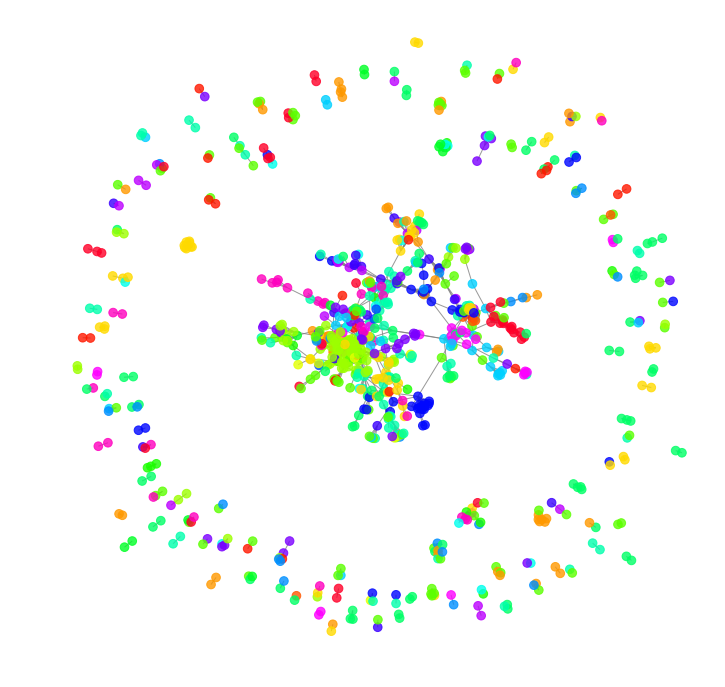

In [77]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Getting a list of all the nodes' classes, in order
classlist=list(nx.get_node_attributes(diseases,'class').values())

#Creating a dictionary associating each class with a unique integer.
classes=set(classlist)
dictionary=dict(zip(classes,range(len(classes))))

#Creating a list of integers corresponding to classes to use for color assignment.
classcolors=[dictionary[x] for x in classlist]

plt.rcParams['figure.figsize']=[12,12]
        
nx.draw_networkx(diseases,
                 pos=nx.spring_layout(diseases,weight='weights'), 
                 cmap=plt.get_cmap('gist_rainbow'), 
                 node_color=classcolors,
                 edge_color='gray',
                 node_size=75,
                 with_labels=False,
                 alpha=.8
                 )
plt.axis('off')

plt.show()

# That would be a big no

Adding the class colors makes beautiful clown-barf, but that's about it.  For small networks, it's easy to see the patterns without using the math, but for larger ones that isn't an option.  

What we've learned from the disease network is that the human disease classification system, which is based on a combination of symptoms and anatomy, does not map onto the genetic mutations that are linked to the diseases.  Diseases with very different classifications can share mutations, while diseases within the same class can be linked to completely different mutations.  This seems to be equally true for all diseases, with the potential exception of a sub-set of blood diseases that do seem to share a unique set of mutations.  

Given the complex interacting nature of genetics, a genetic mutation will probably have different effects depending on the genes around it.  Analyses that incorporate the weights from the graph would help to address this, by including information about how many genetic mutations are shared between diseases.